In [2]:
import pandas as pd
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pa

In [3]:
df = pd.read_excel('CornData.xlsx')

In [4]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 24, 2025",500.30,504.60,505.13,500.10,34.82K,-0.0093
1,"Feb 21, 2025",505.00,512.25,513.75,504.25,235.05K,-0.0151
2,"Feb 20, 2025",512.75,512.00,518.00,511.75,167.19K,0.0010
3,"Feb 19, 2025",512.25,515.25,518.75,511.00,185.42K,-0.0068
4,"Feb 18, 2025",515.75,508.00,517.75,505.50,173.58K,0.0393


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

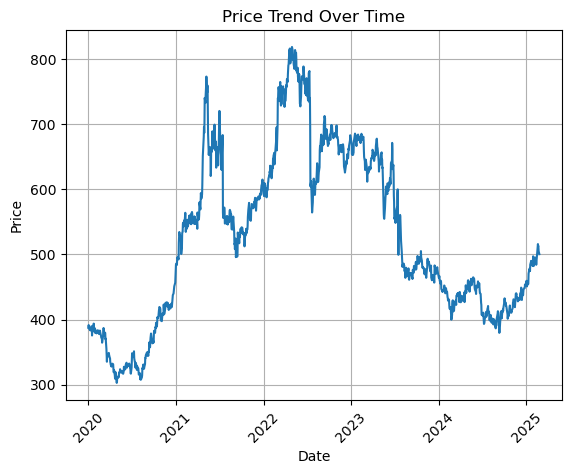

In [6]:
plt.Figure(figsize=(10, 5))
plt.plot(df['Date'], df['Price'], linestyle='-')

# Formatting
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trend Over Time')
plt.xticks(rotation=45)
plt.grid()

# Show plot
plt.show()

plt.show()

In [7]:
df.describe()

,Date,Price,Open,High,Low,Change %
count,1311,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000
mean,2022-07-25 06:57:23.478260736,524.912647,524.575988,530.868810,518.923562,0.000362
min,2020-01-01 00:00:00,302.750000,302.750000,308.500000,300.250000,-0.173900
25%,2021-04-12 12:00:00,420.500000,420.375000,425.125000,417.375000,-0.008750
50%,2022-07-22 00:00:00,497.000000,497.250000,504.000000,492.500000,0.000500
75%,2023-11-06 12:00:00,637.125000,636.500000,644.625000,628.875000,0.009900
max,2025-02-24 00:00:00,818.250000,817.500000,827.000000,814.000000,0.079600
std,NaN,129.527861,129.469635,131.846051,127.264950,0.018130


In [ ]:
# Missing weekend data isn't great... Lets deal with it later.
# ARIMA does require equidistant data to be most effective.

In [8]:
# Test for stationarity

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['Price'])

print('ADF Statistic: %f'% adf_test[0])
print('p-value: %f'% adf_test[1])


ADF Statistic: -1.290728
p-value: 0.633404


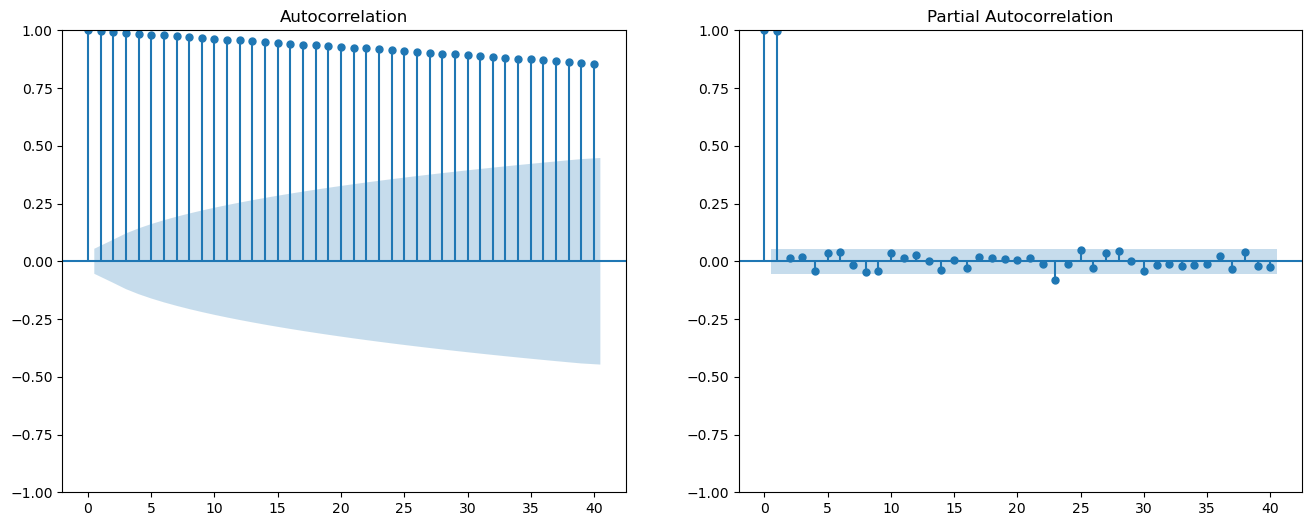

In [9]:
#Seasonality

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(df['Price'], lags=40, alpha=0.05, ax=axes[0])
plot_pacf(df['Price'], lags=40, alpha=0.05, ax=axes[1], method='ywm')

plt.tight_layout
plt.show()


(1048,)
(263,)


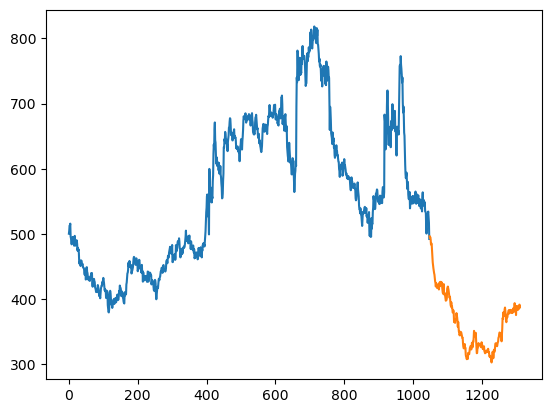

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df['Price'], test_size=0.2, shuffle=False)

print(train.shape)
print(test.shape)

plt.plot(train)
plt.plot(test)

In [11]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(train, d=None, start_p = 2, start_q=0, max_p=5, max_d=5,max_q=5, seasonal=False, stationary=False, error_action='warn', trace=True, suppress_warnings=True, stepwise=True, random_state=69, n_fits=50)


Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8121.540, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8118.584, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8120.318, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8120.303, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8116.584, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8122.256, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.633 seconds


Random Walk, happy days

Lets apply it to our test for shits

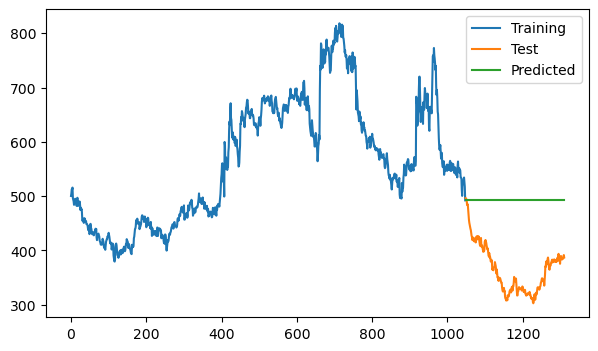

In [34]:
prediction = pd.DataFrame(arima_model.predict(n_periods=263))
prediction.columns = ['predicted_value']


plt.figure(figsize=(7,4))
plt.plot(train, label="Training")
plt.plot(test, label="Test")
plt.plot(prediction, label="Predicted")
plt.legend(loc='upper right')
plt.show()

To do
- check residuals
- Compare with/try SARIMA and/or ARIMAX
- Clean weekend data

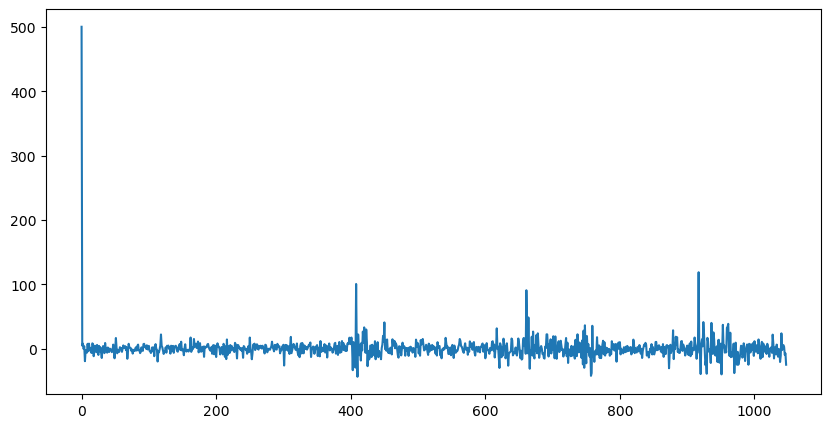

In [36]:
residuals = arima_model.resid()
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.show()

In [ ]:
outlier_indices = residuals[residuals > 70].index
print(outlier_indices)

Index([0, 408, 661, 917], dtype='int64')


Suggests more preporcessing is required or seasonality adaption. Training data needs to be statistically robust.

# My intuition tells me daily data is too granular to capture long term trends and subject to too much noice, making it look like a random walk from one day to the next. Should investigate weekly or monthly data

In [30]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(1, 1, 1))  # Replace 'd' with appropriate differencing value
results = model.fit()

# Print summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1048
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4057.128
Date:                Thu, 27 Mar 2025   AIC                           8120.257
Time:                        16:36:20   BIC                           8135.118
Sample:                             0   HQIC                          8125.892
                               - 1048                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7302      0.597     -1.223      0.221      -1.900       0.440
ma.L1          0.7423      0.586      1.267      0.205      -0.406       1.890
sigma2       135.9251      1.814     74.928      0.0

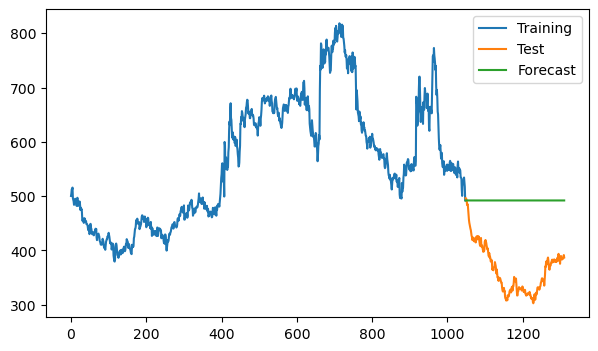

In [31]:
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(7,4))
plt.plot(train, label="Training")
plt.plot(test, label="Test")
plt.plot(forecast, label="Forecast")
plt.legend(loc='upper right')
plt.show()

In [42]:

df = df[['Date', 'Price']]

weekly_data = df.resample('W', on='Date').mean()

print(weekly_data.head())

                 Price
Date                  
2020-01-05  388.416667
2020-01-12  384.500000
2020-01-19  386.150000
2020-01-26  389.312500
2020-02-02  382.400000


In [43]:
adf_test = adfuller(weekly_data['Price'])

print('ADF Statistic: %f'% adf_test[0])
print('p-value: %f'% adf_test[1])

ADF Statistic: -1.656090
p-value: 0.453866


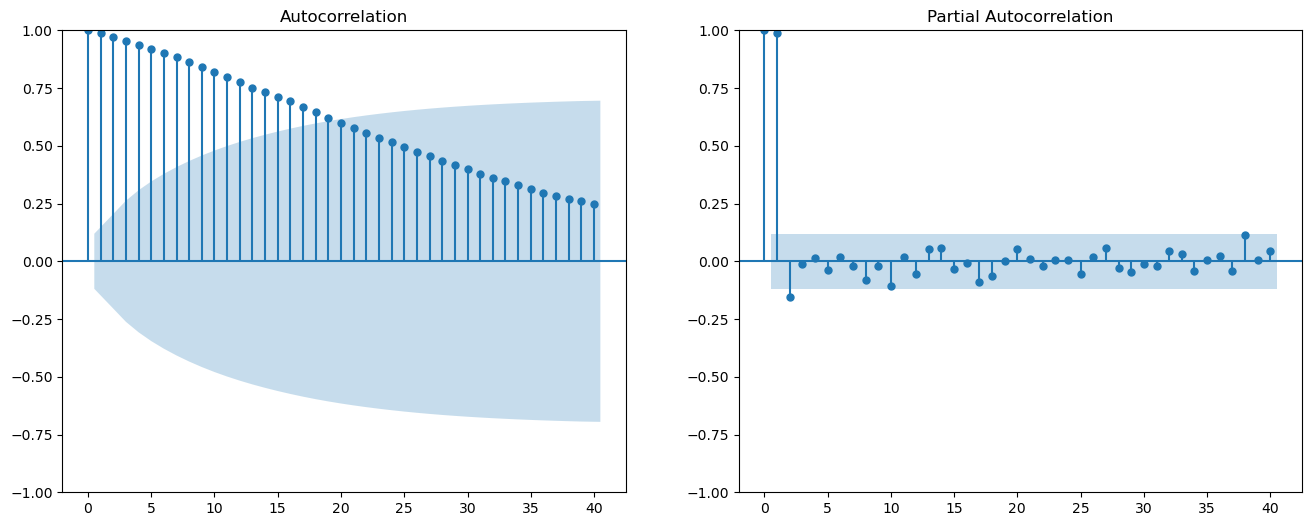

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(weekly_data['Price'], lags=40, alpha=0.05, ax=axes[0])
plot_pacf(weekly_data['Price'], lags=40, alpha=0.05, ax=axes[1], method='ywm')

plt.tight_layout
plt.show()

(216,)
(54,)


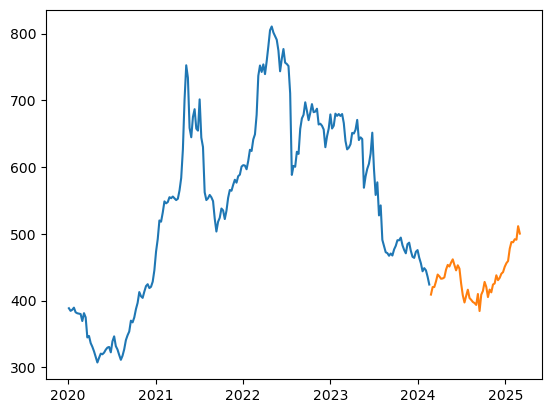

In [45]:
weekly_train, weekly_test = train_test_split(weekly_data['Price'], test_size=0.2, shuffle=False)

print(weekly_train.shape)
print(weekly_test.shape)

plt.plot(weekly_train)
plt.plot(weekly_test)

In [47]:
weekly_arima_model = auto_arima(weekly_train, d=None, start_p = 0, start_q=0, max_p=5, max_d=5,max_q=5, seasonal=False, stationary=False, error_action='warn', trace=True, suppress_warnings=True, stepwise=True, random_state=69, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1919.021, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1913.294, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1913.368, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1917.035, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1915.231, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1915.241, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1917.290, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1911.301, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1913.239, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1913.249, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1911.376, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1915.296, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.504 seconds


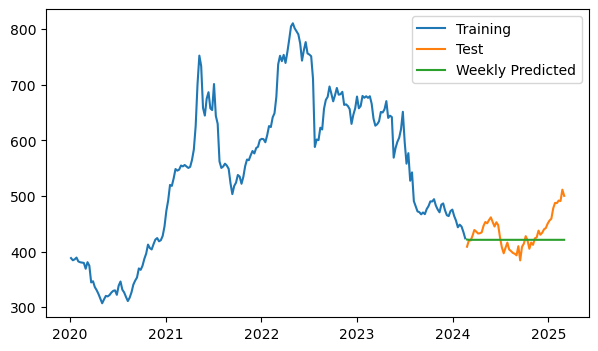

In [48]:
weekly_prediction = pd.DataFrame(weekly_arima_model.predict(n_periods=54))
weekly_prediction.columns = ['predicted_value']


plt.figure(figsize=(7,4))
plt.plot(weekly_train, label="Training")
plt.plot(weekly_test, label="Test")
plt.plot(weekly_prediction, label="Weekly Predicted")
plt.legend(loc='upper right')
plt.show()